<a href="https://colab.research.google.com/github/iainonline/project-pump-public/blob/main/motion_tracking_with_point_extraction_export_graphing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Pump
# Collection and visualization of selected points on a skateboarder over time

**Update - 10/18/2023**

I have taken video of a skater in a bowl and extracted the time, x, z co-ordinates using the Python code in this notebook.

Using time series analysis I will then be able to predict the best time for a skater to 'pump'.


**Observations**

The visulization can be 'flown around'. It is interesting to see clearly the shape of the transition, marked by the two wheel positions, with the relative positions of the skater's head and body.

From the 2D charts I can see the tops of the transitions and indications of the skaters levels of compressed / uncompressed.


**Credit**

This code utilizes the Track Any Pixel In Realtime Project (TAPIR) code.

https://deepmind-tapir.github.io/

Carl Doersch · Yi Yang · Mel Vecerik · Dilara Gokay · Ankush Gupta · Yusuf Aytar · Joao Carreira · Andrew Zisserman

**I have included github commands in the notebook, so that I can reference them for version control usage**

In [15]:
# code cell to create and switch to a new branch

#!git branch
#!git status
#!git checkout -b clean_run_all_git_commands_commented_out

In [16]:
# *** make your changes and check status here ***
# don't forget to save your notebook first to see changes
#!git status

In [17]:
# add files
#!git add "1-480-short.mp4"

In [18]:
# code to commit changes to the new branch
#!git commit -m "clean_run_with_100_frames"

# code to push changes to the new branch on github
#!git push origin clean_run_with_100_frames

In [19]:
# merge the new branch with the master branch
#!git checkout main

In [20]:
# code to merge the new branch with the master branch
#!git merge add_try_except_for_colab

In [21]:
# code to push changes to the master branch on github
#!git push

In [ ]:
%pip install plotly

In [ ]:
%pip install pandas

In [ ]:
# @title Download Code {form-width: "25%"}

# add try except for colab
try:
    !git clone https://github.com/deepmind/tapnet.git
except:
    print("Exception handled")
    pass

In [ ]:
# @title Install Dependencies {form-width: "25%"}
%pip install -r tapnet/requirements_inference.txt

In [ ]:
# @title Download Model {form-width: "25%"}

# code to handle local errors

try:
    %mkdir tapnet/checkpoints
except:
    # if the directory is already created, this cell will throw an error
    print("Directory already created")
    pass

try:
    !wget -P tapnet/checkpoints https://storage.googleapis.com/dm-tapnet/causal_tapir_checkpoint.npy
except:
    # if the model is already downloaded, this cell will throw an error
    print("Model already downloaded")
    pass

try:
    %ls tapnet/checkpoints
except:
    # if the directory is not correct
    print("Directory incorrect")
    pass

In [27]:
# @title Imports {form-width: "25%"}
from IPython.display import HTML

%matplotlib widget
import functools

import haiku as hk
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import mediapy as media
import numpy as np
from tqdm import tqdm
import tree

from tapnet import tapir_model
from tapnet.utils import transforms
from tapnet.utils import viz_utils


# add try except for colab to enable local running and remotely on colaboratory
# 1st tracked change - tested - IM 18/10/2023

try:
    from google.colab import output
    output.enable_custom_widget_manager()
except ImportError:
    print("Not running on colab, no need to enable custom widget manager.")
    pass

Not running on colab, no need to enable custom widget manager.


In [28]:
# @title Load Checkpoint {form-width: "25%"}

checkpoint_path = 'tapnet/checkpoints/causal_tapir_checkpoint.npy'
ckpt_state = np.load(checkpoint_path, allow_pickle=True).item()
params, state = ckpt_state['params'], ckpt_state['state']

In [29]:
# @title Build Model {form-width: "25%"}

# Internally, the tapir model has three stages of processing: computing
# image features (get_feature_grids), extracting features for each query point
# (get_query_features), and estimating trajectories given query features and
# the feature grids where we want to track (estimate_trajectories).  For
# tracking online, we need extract query features on the first frame only, and
# then call estimate_trajectories on one frame at a time.

def build_online_model_init(frames, query_points):
  """Initialize query features for the query points."""
  model = tapir_model.TAPIR(use_causal_conv=True, bilinear_interp_with_depthwise_conv=False)

  feature_grids = model.get_feature_grids(frames, is_training=False)
  query_features = model.get_query_features(
      frames,
      is_training=False,
      query_points=query_points,
      feature_grids=feature_grids,
  )
  return query_features


def build_online_model_predict(frames, query_features, causal_context):
  """Compute point tracks and occlusions given frames and query points."""
  model = tapir_model.TAPIR(use_causal_conv=True, bilinear_interp_with_depthwise_conv=False)
  feature_grids = model.get_feature_grids(frames, is_training=False)
  trajectories = model.estimate_trajectories(
      frames.shape[-3:-1],
      is_training=False,
      feature_grids=feature_grids,
      query_features=query_features,
      query_points_in_video=None,
      query_chunk_size=64,
      causal_context=causal_context,
      get_causal_context=True,
  )
  causal_context = trajectories['causal_context']
  del trajectories['causal_context']
  return {k: v[-1] for k, v in trajectories.items()}, causal_context


online_init = hk.transform_with_state(build_online_model_init)
online_init_apply = jax.jit(online_init.apply)

online_predict = hk.transform_with_state(build_online_model_predict)
online_predict_apply = jax.jit(online_predict.apply)

rng = jax.random.PRNGKey(42)
online_init_apply = functools.partial(
    online_init_apply, params=params, state=state, rng=rng
)
online_predict_apply = functools.partial(
    online_predict_apply, params=params, state=state, rng=rng
)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [30]:
# @title Utility Functions {form-width: "25%"}

def preprocess_frames(frames):
  """Preprocess frames to model inputs.

  Args:
    frames: [num_frames, height, width, 3], [0, 255], np.uint8

  Returns:
    frames: [num_frames, height, width, 3], [-1, 1], np.float32
  """
  frames = frames.astype(np.float32)
  frames = frames / 255 * 2 - 1
  return frames


def postprocess_occlusions(occlusions, expected_dist):
  """Postprocess occlusions to boolean visible flag.

  Args:
    occlusions: [num_points, num_frames], [-inf, inf], np.float32

  Returns:
    visibles: [num_points, num_frames], bool
  """
  pred_occ = jax.nn.sigmoid(occlusions)
  pred_occ = 1 - (1 - pred_occ) * (1 - jax.nn.sigmoid(expected_dist))
  visibles = pred_occ < 0.5  # threshold
  return visibles


def sample_random_points(frame_max_idx, height, width, num_points):
  """Sample random points with (time, height, width) order."""
  y = np.random.randint(0, height, (num_points, 1))
  x = np.random.randint(0, width, (num_points, 1))
  t = np.random.randint(0, frame_max_idx + 1, (num_points, 1))
  points = np.concatenate((t, y, x), axis=-1).astype(np.int32)  # [num_points, 3]
  return points


def construct_initial_causal_state(num_points, num_resolutions):
  value_shapes = {
      "tapir/~/pips_mlp_mixer/block_1_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_1_causal_2": (1, num_points, 2, 2048),
      "tapir/~/pips_mlp_mixer/block_2_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_2_causal_2": (1, num_points, 2, 2048),
      "tapir/~/pips_mlp_mixer/block_3_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_3_causal_2": (1, num_points, 2, 2048),
      "tapir/~/pips_mlp_mixer/block_4_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_4_causal_2": (1, num_points, 2, 2048),
      "tapir/~/pips_mlp_mixer/block_5_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_5_causal_2": (1, num_points, 2, 2048),
      "tapir/~/pips_mlp_mixer/block_6_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_6_causal_2": (1, num_points, 2, 2048),
      "tapir/~/pips_mlp_mixer/block_7_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_7_causal_2": (1, num_points, 2, 2048),
      "tapir/~/pips_mlp_mixer/block_8_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_8_causal_2": (1, num_points, 2, 2048),
      "tapir/~/pips_mlp_mixer/block_9_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_9_causal_2": (1, num_points, 2, 2048),
      "tapir/~/pips_mlp_mixer/block_10_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_10_causal_2": (1, num_points, 2, 2048),
      "tapir/~/pips_mlp_mixer/block_11_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_11_causal_2": (1, num_points, 2, 2048),
      "tapir/~/pips_mlp_mixer/block_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_causal_2": (1, num_points, 2, 2048),
  }
  fake_ret = {
      k: jnp.zeros(v, dtype=jnp.float32) for k, v in value_shapes.items()
  }
  return [fake_ret] * num_resolutions * 4

In [31]:
# read in the video

# use short video for testing
videoname = '1-480-short.mp4'

video = media.read_video(videoname)

# print how many frames are in the video

print(str(video.shape[0]) + ' frames in video')

187 frames in video


In [32]:
# prompt: reduce video to framestoprocess length
framestoprocess = 20  # @param {type: "integer"}
video = video[:framestoprocess]

In [33]:
# scale video

height, width = video.shape[1:3]

In [34]:
# @title Progressively Predict Sparse Point Tracks {form-width: "25%"}

resize_height = 128  # @param {type: "integer"}
resize_width = 128  # @param {type: "integer"}
num_points = 20  # @param {type: "integer"}

frames = media.resize_video(video, (resize_height, resize_width))
query_points = sample_random_points(0, frames.shape[1], frames.shape[2], num_points)

query_features, _ = online_init_apply(frames=preprocess_frames(frames[None, None, 0]), query_points=query_points[None])
causal_state = construct_initial_causal_state(query_points.shape[0], len(query_features.resolutions) - 1)

# Predict point tracks frame by frame
predictions = []
for i in tqdm (range (frames.shape[0]), desc="Processing frames"):
  (prediction, causal_state), _ = online_predict_apply(
      frames=preprocess_frames(frames[None, None, i]),
      query_features=query_features,
      causal_context=causal_state,
  )
  predictions.append(prediction)

tracks = np.concatenate([x['tracks'][0] for x in predictions], axis=1)
occlusions = np.concatenate([x['occlusion'][0] for x in predictions], axis=1)
expected_dist = np.concatenate([x['expected_dist'][0] for x in predictions], axis=1)

visibles = postprocess_occlusions(occlusions, expected_dist)

# Visualize sparse point tracks
tracks = transforms.convert_grid_coordinates(tracks, (resize_width, resize_height), (width, height))
video_viz = viz_utils.paint_point_track(video, tracks, visibles)

Processing frames: 100%|██████████| 20/20 [01:03<00:00,  3.19s/it]


Using co-ordinates below for this specific video
420 184
421 230
412 310
446 306


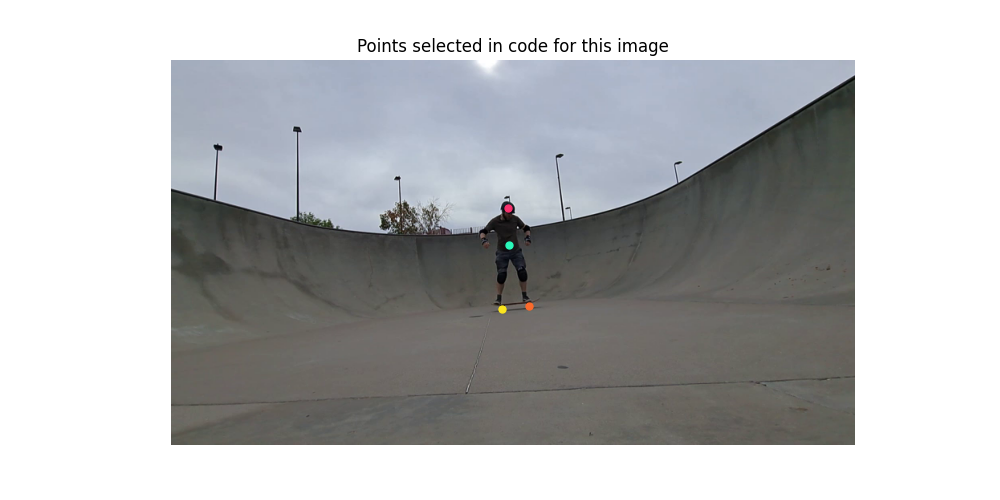

In [35]:
# @title Select Any Points at First Frame {form-width: "25%"}

# Generate a colormap with 20 points, no need to change unless select more than 20 points
colormap = viz_utils.get_colors(20)

fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(video[0])
ax.axis('off')
ax.set_title('Points selected in code for this image')

select_points = [420,184],[421,230],[412,310],[446,306]

# loop through the points and plot them on the image

print('Using co-ordinates below for this specific video')

for i in range(len(select_points)):
  x, y = select_points[i]
  color = colormap[i]
  color = tuple(np.array(color) / 255.0)
  ax.plot(x, y, 'o', color=color, markersize=5)
  print(x, y)
plt.draw()

In [36]:
print('Selected points: ', select_points)

# export the selected points to a csv file

np.savetxt('points.csp', select_points, delimiter=',')

Selected points:  ([420, 184], [421, 230], [412, 310], [446, 306])


In [37]:
# @title Predict Point Tracks for the Selected Points {form-width: "25%"}

resize_height = 128  # @param {type: "integer"}
resize_width = 128  # @param {type: "integer"}

def convert_select_points_to_query_points(frame, points):
  """Convert select points to query points.

  Args:
    points: [num_points, 2], [t, y, x]
  Returns:
    query_points: [num_points, 3], [t, y, x]
  """
  points = np.stack(points)
  query_points = np.zeros(shape=(points.shape[0], 3), dtype=np.float32)
  query_points[:, 0] = frame
  query_points[:, 1] = points[:, 1]
  query_points[:, 2] = points[:, 0]
  return query_points

frames = media.resize_video(video, (resize_height, resize_width))
query_points = convert_select_points_to_query_points(0, select_points)
query_points = transforms.convert_grid_coordinates(
    query_points, (1, height, width), (1, resize_height, resize_width), coordinate_format='tyx')

query_features, _ = online_init_apply(frames=preprocess_frames(frames[None, None, 0]), query_points=query_points[None])
causal_state = construct_initial_causal_state(query_points.shape[0], len(query_features.resolutions) - 1)

# Predict point tracks frame by frame
predictions = []
for i in tqdm(range(frames.shape[0])):
  (prediction, causal_state), _ = online_predict_apply(
      frames=preprocess_frames(frames[None, None, i]),
      query_features=query_features,
      causal_context=causal_state,
  )
  predictions.append(prediction)

tracks = np.concatenate([x['tracks'][0] for x in predictions], axis=1)
occlusions = np.concatenate([x['occlusion'][0] for x in predictions], axis=1)
expected_dist = np.concatenate([x['expected_dist'][0] for x in predictions], axis=1)

visibles = postprocess_occlusions(occlusions, expected_dist)

# Visualize sparse point tracks
tracks = transforms.convert_grid_coordinates(tracks, (resize_width, resize_height), (width, height))
video_viz = viz_utils.paint_point_track(video, tracks, visibles, colormap)

100%|██████████| 20/20 [00:46<00:00,  2.32s/it]


In [38]:
#save the video to the current directory
media.write_video('output.mp4', video_viz, fps=24)

In [39]:
# extract tracks into plotable arrays

# select track 0 all elements in dimension 1
y = tracks[0,:,0]
# select track 0 all elements in dimension 2
z = tracks[0,:,1]

# set x to be a range of values from 0 to the length of y
x = np.arange(0,len(y))

# select track 1 all elements in dimension 1
yy = tracks[1,:,0]
# select track 1 all elements in dimension 2
zz = tracks[1,:,1]

# select track 2 all elements in dimension 1
yyy = tracks[2,:,0]
# select track 2 all elements in dimension 2
zzz = tracks[2,:,1]

# select track 3 all elements in dimension 1
yyyy = tracks[3,:,0]
# select track 3 all elements in dimension 2
zzzz = tracks[3,:,1]

In [40]:
import pandas as pd

dftracks = pd.DataFrame()

for j in range(tracks.shape[1]):
    for i in range(tracks.shape[0]):
        for k in range(tracks.shape[2]):
            if k == 0:
              xvalue = tracks[i][j][k]
            if k == 1:
              yvalue = tracks[i][j][k]

        dataToAppend = pd.DataFrame({
            'frame': [j],
            'point': [i],
            'X': [xvalue],
            'Y': [yvalue]
        })
        dftracks = pd.concat([dftracks, dataToAppend], ignore_index=True)

In [41]:
import plotly.graph_objs as go

# Get unique point numbers
points = dftracks['point'].unique()

# Create a new figure object
fig = go.Figure()

# Create a separate trace for each point
for point in points:
    # Filter the DataFrame for the current point
    data = dftracks[dftracks['point'] == point]

    # Create a new trace for the current point
    trace = go.Scatter3d(
        x=data['frame'],
        y=data['X'],
        z=data['Y'],
        name=f"Point {point}"
    )

    # Add the trace to the figure object
    fig.add_trace(trace)

# Set the layout of the plot
fig.update_layout(
    title="Plot of time against x and y location for each tracked point (2 x wheels, head and chest)",
    scene=dict(
        xaxis_title="Frame",
        yaxis_title="Y",
        zaxis_title="X"
    )
)
# Show the plot
fig.show()

In [42]:
video_viz = video_viz[:10]
media.show_video(video_viz, fps=10)

In [43]:
# prompt: Using dataframe dftracks: export to a .csv file

dftracks.to_csv('dftracks.csv')
print('Data points exported to dftracks.csv')

Data points exported to dftracks.csv


In [44]:
# display tracks dataframe head
dftracks.head()

,frame,point,X,Y
0,0,0,419.851556,185.910430
1,0,1,422.501167,231.862278
2,0,2,414.379392,309.274492
3,0,3,444.198297,307.433224
4,1,0,426.267627,185.368552


In [45]:
# plot each point as a scatter plot with time on the x axis and x coordinate on the y axis

# get unique point numbers
points = dftracks['point'].unique()

# create a new figure object
fig = go.Figure()

# create a separate trace for each point

for point in points:
    # filter the dataframe for the current point
    data = dftracks[dftracks['point'] == point]

    # create a new trace for the current point
    trace = go.Scatter(
        x=data['frame'],
        y=data['X'],
        name=f"Point {point}"
    )

    # add the trace to the figure object
    fig.add_trace(trace)

# set the layout of the plot
fig.update_layout(
    title="Plot of time against x location for each tracked point (2 x wheels, head and chest)",
    xaxis_title="Frame",
    yaxis_title="X"
)
# show the plot
fig.show()

In [46]:
# plot each point as a scatter plot with time on the x axis and y coordinate on the y axis

# get unique point numbers
points = dftracks['point'].unique()

# create a new figure object
fig = go.Figure()

# create a separate trace for each point

for point in points:
    # filter the dataframe for the current point
    data = dftracks[dftracks['point'] == point]

    # create a new trace for the current point
    trace = go.Scatter(
        x=data['frame'],
        y=data['Y'],
        name=f"Point {point}"
    )

    # add the trace to the figure object
    fig.add_trace(trace)

# set the layout of the plot

fig.update_layout(
    title="Plot of time against y location for each tracked point (2 x wheels, head and chest)",
    xaxis_title="Frame",
    yaxis_title="Y"
)

# show the plot
fig.show()